# IMPORT, CONFIGURE & SET SEED

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn as sk 
import re 
import html 
import os 
import nltk
import bs4
import random

In [ ]:
# REPRODUCIBILITY 
SEED = 42

def set_global_seed(seed):
    """
    Locks random number generators for reproducibility.
    """
    random.seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    np.random.seed(seed)
    
    print(f"Global Random Seed set to: {seed}")

set_global_seed(SEED)

Global Random Seed set to: 42


In [3]:
plt.style.use('ggplot')
sns.set_palette("viridis")

# EXPLORATION

In [4]:
df = pd.read_csv("./dataset/development.csv")

## a. Basics

In [5]:
print("DataFrame Structure")
print(df.info())

DataFrame Structure
<class 'pandas.DataFrame'>
RangeIndex: 79997 entries, 0 to 79996
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         79997 non-null  int64
 1   source     79997 non-null  str  
 2   title      79996 non-null  str  
 3   article    79996 non-null  str  
 4   page_rank  79997 non-null  int64
 5   timestamp  79997 non-null  str  
 6   label      79997 non-null  int64
dtypes: int64(3), str(4)
memory usage: 4.3 MB
None


In [6]:
print("\nSample Rows")
display(df.head())


Sample Rows


,Id,source,title,article,page_rank,timestamp,label
0,0,AllAfrica.com,OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd,THE Organisation of Petroleum Exporting Countr...,5,2004-09-16 22:39:53,5
1,1,Xinhua,Yearender: Mideast peace roadmap reaches dead-...,Looking back at the major events that took pla...,5,2004-12-17 19:01:14,0
2,2,Yahoo,Battleground Dispatches for Oct. 5 \\n (CQP...,CQPolitics.com - Here are today's Battleground...,5,2006-10-05 18:42:29,0
3,3,BBC,Air best to resuscitate newborns,Air rather than oxygen should be used to resus...,5,0000-00-00 00:00:00,0
4,4,Yahoo,High tech German train crash kills at least on...,"<p><a href=""http://us.rd.yahoo.com/dailynews/r...",5,2006-09-22 17:28:57,0


## b. Class Distribution

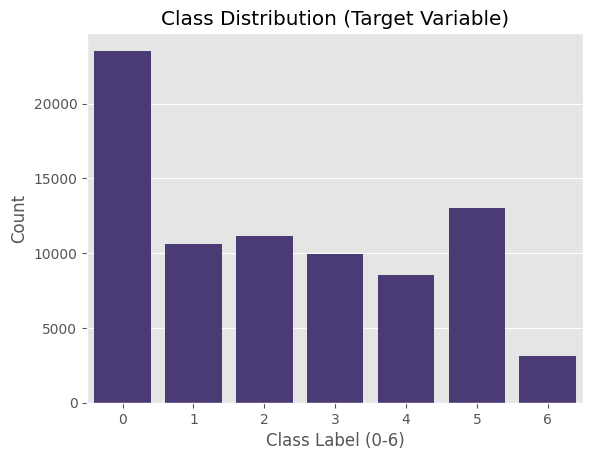

In [7]:
plt.figure()
ax = sns.countplot(data=df, x='label')
plt.title("Class Distribution (Target Variable)")
plt.xlabel("Class Label (0-6)")
plt.ylabel("Count")
plt.show()

If our metric were Accuracy, I could ignore the imbalance. The model would just guess the majority class (Label 0) most of the time and get a high score.

However, our metric is Macro-F1. This calculates the F1 score for each class separately and then takes the average.

We can use class weights, synthetic over-sampling or undersampling. The most plug-and-play option is class weights.


## c. Timestamps

In [8]:
print("\nTimestamp")
print("Top 5 unique timestamp values:")
print(df['timestamp'].value_counts().head())


Timestamp
Top 5 unique timestamp values:
timestamp
0000-00-00 00:00:00    27750
2007-02-12 12:39:51        2
2007-06-22 18:43:49        2
2007-07-24 01:27:26        2
2007-02-01 07:14:50        2
Name: count, dtype: int64


In [5]:
temp_dates = pd.to_datetime(df['timestamp'], errors='coerce')
n_invalid = temp_dates.isna().sum()
print(f"\nInvalid Dates (NaT after coercion): {n_invalid}")
print(f"Percentage of missing/invalid dates: {n_invalid / len(df)}")


Invalid Dates (NaT after coercion): 27750
Percentage of missing/invalid dates: 0.34688800830031125


27,750 rows have no date.

We will assume undated articles are old (or at least, safe to train on).

When sorting by date, we are going to place NaT values at the beginning (na_position='first').

The NaT rows will inevitably fall into the Training Set (first 80%). The Validation Set (last 20%) will strictly contain the most recent valid dates. This guarantees our validation score is a like a test of "predicting the future."

## d. Missing Values

In [6]:
print("Rows with Missing Values")
missing_rows = df[df.isnull().any(axis=1)]
display(missing_rows)

Rows with Missing Values


,Id,source,title,article,page_rank,timestamp,label
26038,26038,Forbes,NaN,\N,5,2004-11-19 23:47:53,1
53004,53004,CNET,"20,000 more H1-B visas",NaN,3,0000-00-00 00:00:00,2


We have identified a specific data artifact: \N. This is a standard NULL placeholder used in database dumps. Its presence tells us that these aren't just "short" texts; they are database errors.

We need to implement a cleaning step that handles these specific artifacts (\N, ,,) before we check lengths.

In [ ]:
def scrub_artifacts(text):
    if pd.isna(text): return ""
    # Remove database nulls and weird comma artifacts
    clean = str(text).replace(r'\N', '').replace(',,', '').replace(', ,', '').replace(',  ,', '')  
    clean = re.sub(r'\s+', ' ', clean)  
    return clean.strip()

In [ ]:
df['title'] = df['title'].apply(scrub_artifacts)
df['article'] = df['article'].apply(scrub_artifacts)
df['source'] = df['source'].apply(scrub_artifacts)

In [9]:
df['source'] = df['source'].replace('', 'Unknown')

In [ ]:
df['text_blob'] = df['title'] + " " + df['article']
df['text_len'] = df['text_blob'].str.len()

# Thresholds
DROP_THRESHOLD = 25
INSPECTION_LIMIT = 50  

# Filter for inspection
short_rows = df[df['text_len'] < INSPECTION_LIMIT].copy()

print(f"\n--- Analysis of Short Texts (Length < {INSPECTION_LIMIT}) ---")
print(f"Count: {len(short_rows)} rows")

if len(short_rows) > 0:
    print(f"\n1. GARBAGE CANDIDATES (< {DROP_THRESHOLD} chars):")

    garbage = short_rows[short_rows['text_len'] < DROP_THRESHOLD]
    display(garbage[['source', 'title', 'article', 'text_len', 'label']].sort_values(by='text_len').head(10))
    
    print(f"\n2. BORDERLINE CASES ({DROP_THRESHOLD}-{INSPECTION_LIMIT} chars):")

    borderline = short_rows[short_rows['text_len'] >= DROP_THRESHOLD]
    display(borderline[['source', 'title', 'article', 'text_len', 'label']].sort_values(by='text_len').head(10))
    
    print("\nClass Distribution of All Short Rows:")
    print(short_rows['label'].value_counts())
else:
    print("No short rows found.")


--- Analysis of Short Texts (Length < 50) ---
Count: 1603 rows

1. GARBAGE CANDIDATES (< 25 chars):


,source,title,article,text_len,label
26038,Forbes,,,1,1
43282,Washington,FINDINGS,,9,5
65983,Forbes,Ron Loses,,10,1
63356,Newsweek,Newsmakers,,11,5
24311,Forbes,ETF-O-Mania,,12,1
75568,Forbes,GoogleTube?,,12,1
49565,Forbes,Help Wanted,,12,1
4201,Washington,CORRECTIONS,,12,5
73676,Unknown,Booby Prize,,12,1
43882,Newsweek,Kingdom Kong,,13,5



2. BORDERLINE CASES (25-50 chars):


,source,title,article,text_len,label
14610,CNN,Holiday travel is stormy,,25,5
62149,CNN,U.S. honors war veterans,,25,5
29704,CNN,Musicians rock for Kerry,,25,5
46387,Forbes,"News Scan: Nov. 11, 2004",,25,1
29016,CNN,Inauguration Day history,,25,5
63470,CNN,Help for tsunami victims,,25,5
63676,Forbes,"News Scan: Nov. 18, 2004",,25,1
11057,CNN,Flavors for the holidays,,25,5
26964,CNN,U.S. Navy copter crashes,,25,5
44199,International,The time for green roofs,,25,1



Class Distribution of All Short Rows:
label
5    882
1    641
2     35
3     21
0     19
4      5
Name: count, dtype: int64


## e. Source Analysis

In [11]:
print(f"Unique Sources: {df['source'].nunique()}")
print("\nTop 10 Sources:")
print(df['source'].value_counts().head(10))
print("\n Median of Article per Source:")
print(df['source'].value_counts().median())
print("\n Mode of Source (Most frequent total Articles for Sources)")
print(df['source'].value_counts().mode())
print("\n Average Article per Source")
print(df["source"].value_counts().sum()/len(df["source"].value_counts()))

Unique Sources: 1359

Top 10 Sources:
source
Yahoo         15850
Reuters       11915
BBC            7971
New            6430
Washington     3383
RedNova        2701
Boston         1807
CNN            1802
CNET           1369
Topix.Net      1331
Name: count, dtype: int64

 Median of Article per Source:
2.0

 Mode of Source (Most frequent total Articles for Sources)
0    1
Name: count, dtype: int64

 Average Article per Source
58.86460632818249


We have 1,359 sources, but the median frequency is just 2. This means hundreds of sources appear only once.

If we One-Hot Encode all, our feature space explodes with useless columns. If a source appears once in Train and never in Validation, the model learns a rule it can never use.

We'll keep the top 50 sources.

Map the remaining ~1,300 sources to a single category: "Other".

## f. Article Lengths

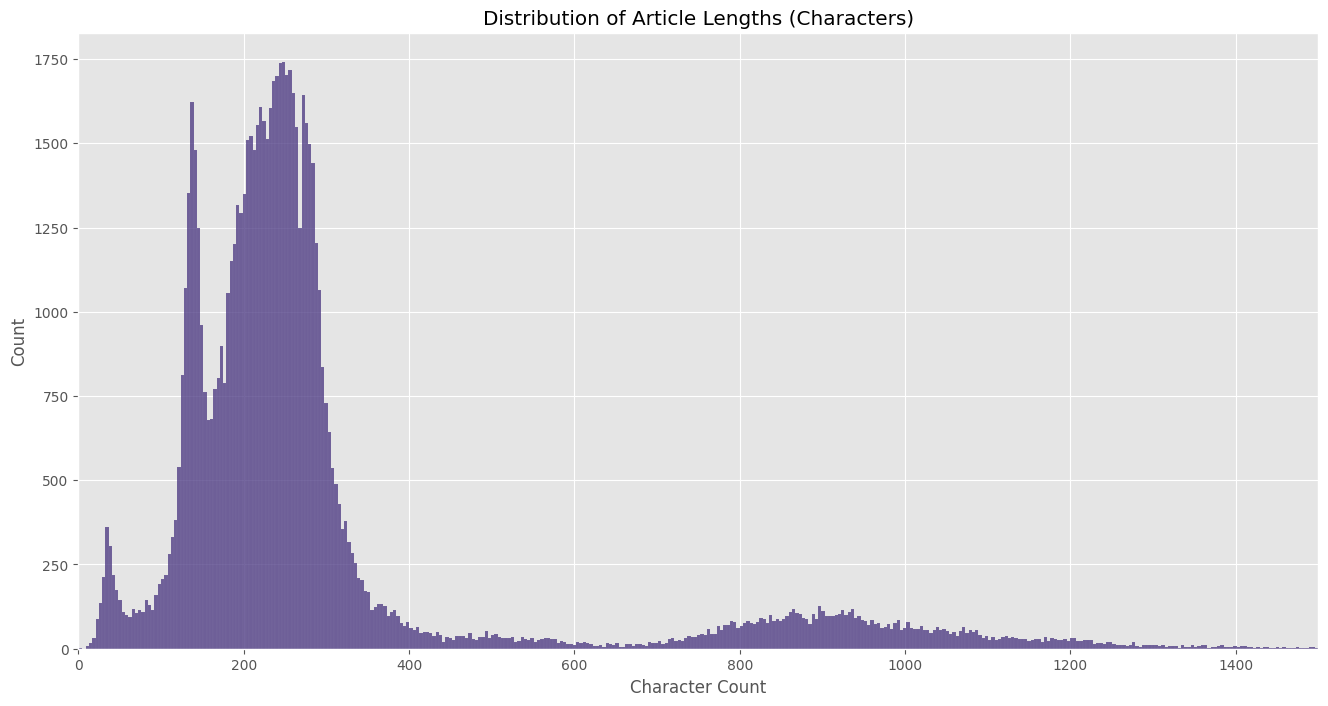

In [12]:
plt.figure(figsize=(16, 8))
sns.histplot(df['text_len'], bins=4000)
plt.title("Distribution of Article Lengths (Characters)")
plt.xlim(0, 1500) 
plt.xlabel("Character Count")
plt.show()

In [17]:
# Quick Stat Check for Outliers
print("\n--- Length Statistics ---")
print(df['text_len'].describe())


--- Length Statistics ---
count    79997.000000
mean       321.107967
std        362.021098
min          1.000000
25%        183.000000
50%        240.000000
75%        289.000000
max      16343.000000
Name: text_len, dtype: float64


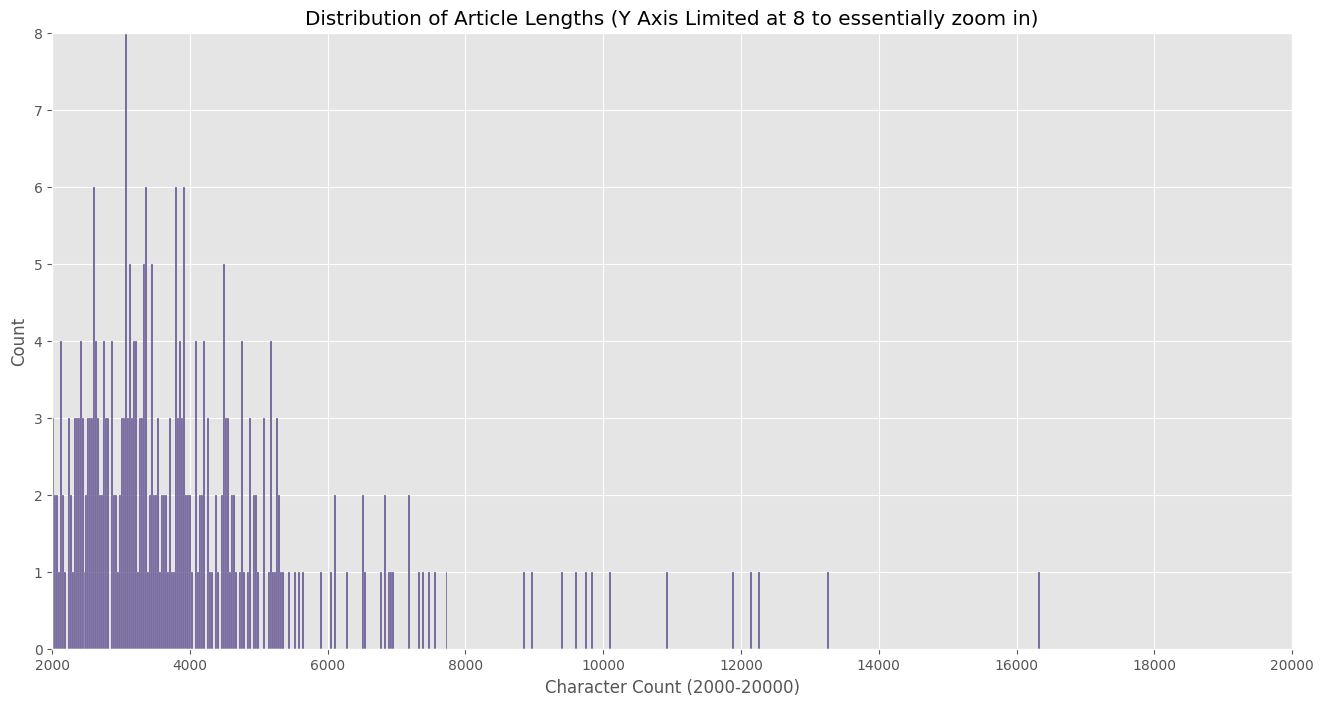

In [18]:
plt.figure(figsize=(16, 8))
sns.histplot(df['text_len'])
plt.title("Distribution of Article Lengths (Y Axis Limited at 8 to essentially zoom in)")
plt.xlim(2000, 20000)
plt.ylim(0,8) 
plt.xlabel("Character Count (2000-20000)")
plt.show()

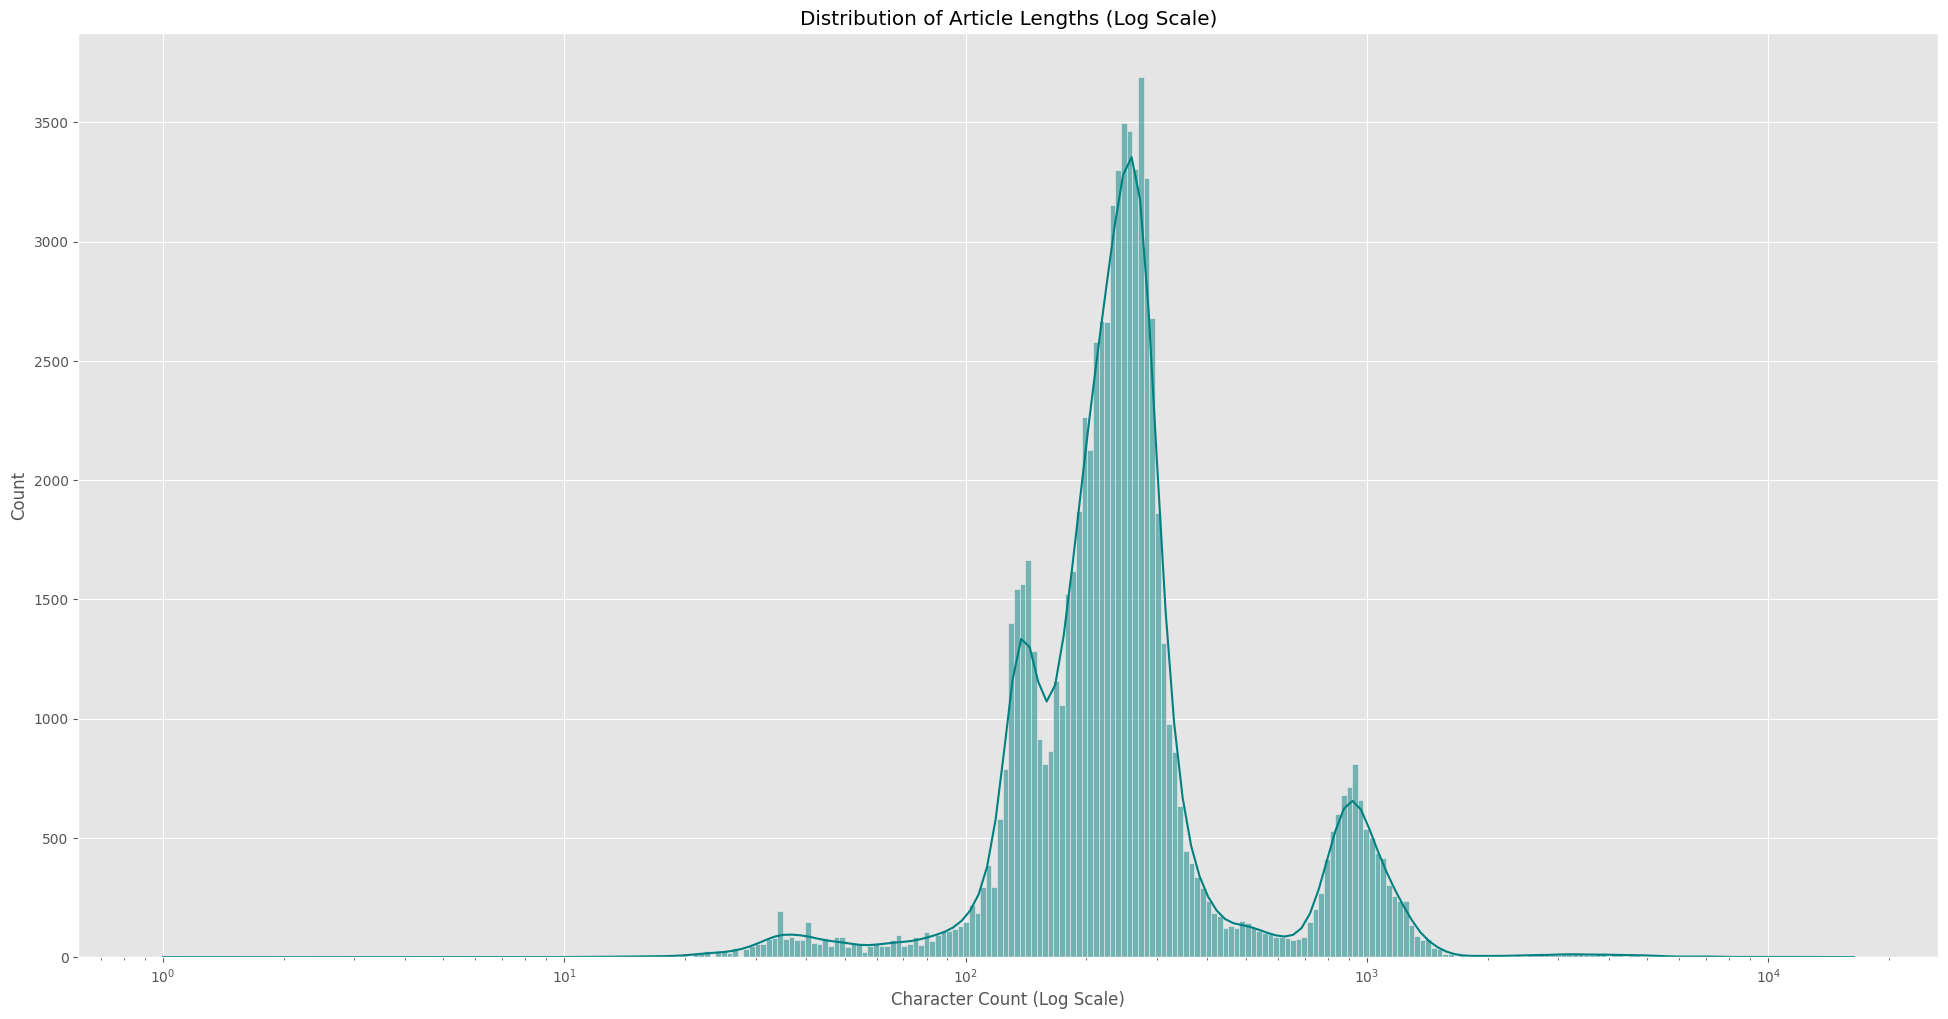

In [19]:
plt.figure(figsize=(24,12))
sns.histplot(df['text_len'], log_scale=True, kde=True, color='teal', bins=300)
plt.title("Distribution of Article Lengths (Log Scale)")
plt.xlabel("Character Count (Log Scale)")
plt.show()

## g. Page Rank Investigation

PageRank Analysis
count    79997.000000
mean         4.892958
std          0.397603
min          2.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: page_rank, dtype: float64

Max unique PageRanks per Source: 3


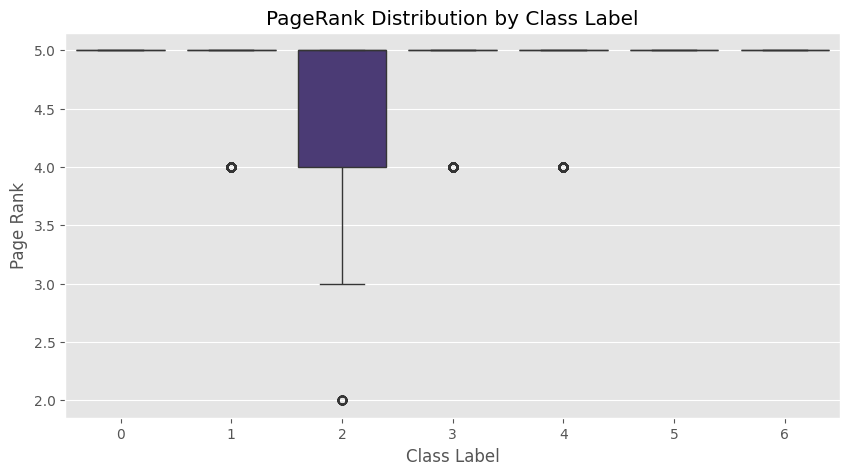

In [13]:
print("PageRank Analysis")
print(df['page_rank'].describe())

# Is PageRank just a static number for each Source?
pr_per_source = df.groupby('source')['page_rank'].nunique()
print(f"\nMax unique PageRanks per Source: {pr_per_source.max()}")

# Visualization: Does PageRank correlate with the Label?
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='label', y='page_rank')
plt.title("PageRank Distribution by Class Label")
plt.xlabel("Class Label")
plt.ylabel("Page Rank")
plt.show()

# CLEANING & SPLITTING

In [ ]:
initial_count = len(df)

df_clean = df[df['text_len'] >= DROP_THRESHOLD].copy()
dropped_count = initial_count - len(df_clean)

print(f"Filtering Result")
print(f"Dropped {dropped_count} rows (insufficient text content < {DROP_THRESHOLD} chars).")
print(f"Remaining Rows: {len(df_clean)}")

Filtering Result
Dropped 147 rows (insufficient text content < 25 chars).
Remaining Rows: 79850


In [15]:
print("\nSorting by Time")
# Convert timestamp, coerce errors to NaT
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')

df_sorted = df_clean.sort_values(by='timestamp', na_position='first').reset_index(drop=True)

print("Data sorted chronologically (NaT values pushed to start).")

# TIME-SERIES SPLIT (80/20)

train_size = int(0.8 * len(df_sorted))

X_full = df_sorted.drop(columns=['label'])
y_full = df_sorted['label']

X_train = X_full.iloc[:train_size]
y_train = y_full.iloc[:train_size]

X_val = X_full.iloc[train_size:]
y_val = y_full.iloc[train_size:]

print(f"\nFinal Split Summary")
print(f"Train Set: {len(X_train)} rows ({len(X_train)/len(df_sorted):.1%})")
print(f"Val Set:   {len(X_val)} rows ({len(X_val)/len(df_sorted):.1%})")

# Verify that Validation strictly follows Training in time
val_dates = X_val['timestamp'].dropna()

train_max = X_train['timestamp'].max()
val_min = X_val['timestamp'].min()
    
print(f"\n--- Leakage Verification ---")
print(f"Train Max Date: {train_max}")
print(f"Val Min Date:   {val_min}")
    
is_valid = train_max <= val_min
print(f"Leakage Check Passed: {is_valid}")
    
if not is_valid:
    print("WARNING: There is time overlap between Train and Val. Check sorting logic!")


Sorting by Time
Data sorted chronologically (NaT values pushed to start).

Final Split Summary
Train Set: 63880 rows (80.0%)
Val Set:   15970 rows (20.0%)

--- Leakage Verification ---
Train Max Date: 2007-08-26 12:37:02
Val Min Date:   2007-08-26 12:59:38
Leakage Check Passed: True


# ENCODING

Top 10 Sources cover 68.3% of the data.
Top 20 Sources cover 77.2% of the data.
Top 50 Sources cover 86.7% of the data.
Top 100 Sources cover 91.3% of the data.
Top 200 Sources cover 95.0% of the data.
Top 300 Sources cover 96.6% of the data.
Top 500 Sources cover 98.1% of the data.
Top 1000 Sources cover 99.6% of the data.


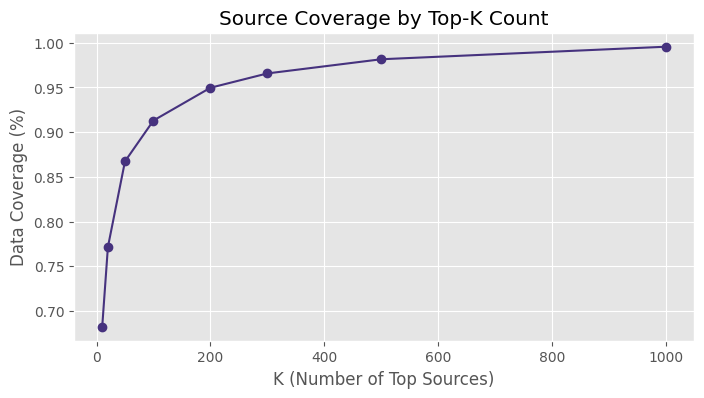

In [16]:
k_values = [10, 20, 50, 100, 200, 300, 500, 1000]
coverage = []

for k in k_values:
    top_sources = df_clean['source'].value_counts().nlargest(k).index
    mask = df_clean['source'].isin(top_sources)
    cov = mask.mean()
    coverage.append(cov)
    print(f"Top {k} Sources cover {cov:.1%} of the data.")

# Plot the "Elbow" of source coverage
plt.figure(figsize=(8, 4))
plt.plot(k_values, coverage, marker='o')
plt.title("Source Coverage by Top-K Count")
plt.xlabel("K (Number of Top Sources)")
plt.ylabel("Data Coverage (%)")
plt.grid(True)
plt.show()

Top 200 Sources cover 95.0% of all articles.

The gain from going to 500 or 1000 is marginal (only +4.6% coverage for 5x more features).

Decision: We lock in K=200. This captures almost all the signal while keeping the Source feature vector dense and efficient.

In [17]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack


# SOURCE ENCODING (Top-200 + 'Other')
print("Source Encoding")
TOP_K = 200
# Identify top K sources from TRAINING set only (No peeking!)
top_sources = X_train['source'].value_counts().nlargest(TOP_K).index.tolist()
print(f"Top Sources identified: {len(top_sources)}")

# Helper to map sources
def map_sources(series, top_k_list):
    return series.apply(lambda x: x if x in top_k_list else 'Other')

# Apply mapping
X_train_src = map_sources(X_train['source'], top_sources).values.reshape(-1, 1)
X_val_src = map_sources(X_val['source'], top_sources).values.reshape(-1, 1)

# One-Hot Encode
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train_ohe = ohe.fit_transform(X_train_src)
X_val_ohe = ohe.transform(X_val_src)

print(f"OHE Train Shape: {X_train_ohe.shape}")
print(f"OHE Val Shape:   {X_val_ohe.shape}")

# PAGERANK SCALING (MinMax)
print("\nPageRank Scaling")
scaler = MinMaxScaler()

# Reshape to 2D array for sklearn
X_train_pr = X_train['page_rank'].values.reshape(-1, 1)
X_val_pr = X_val['page_rank'].values.reshape(-1, 1)

X_train_pr_scaled = scaler.fit_transform(X_train_pr)
X_val_pr_scaled = scaler.transform(X_val_pr)

# Convert to sparse matrix for concatenation later
from scipy.sparse import csr_matrix
X_train_pr_sparse = csr_matrix(X_train_pr_scaled)
X_val_pr_sparse = csr_matrix(X_val_pr_scaled)

print(f"PageRank Scaled Min: {X_train_pr_scaled.min()}, Max: {X_train_pr_scaled.max()}")

Source Encoding
Top Sources identified: 200
OHE Train Shape: (63880, 201)
OHE Val Shape:   (15970, 201)

PageRank Scaling
PageRank Scaled Min: 0.0, Max: 0.9999999999999999


In [18]:
# Check if 'Unknown' made it into the Top 200
is_unknown_kept = 'Unknown' in top_sources

print(f"Is 'Unknown' in the Top {TOP_K} sources? {is_unknown_kept}")

Is 'Unknown' in the Top 200 sources? True


In [19]:
# TEXT VECTORIZATION (TF-IDF)
print("\nText Vectorization")
# Concatenate columns: Source + Title + Article
# We include Source here too because the *words* in the source name (e.g., "Financial") might be useful tokens
X_train_text = (X_train['source'].fillna('') + " " + X_train['title'].fillna('') + " " + X_train['article'].fillna(''))
X_val_text = (X_val['source'].fillna('') + " " + X_val['title'].fillna('') + " " + X_val['article'].fillna(''))

# Initialize TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1, 3), 
    max_features=30000, 
    sublinear_tf=True, 
    min_df=5
)

# Fit on Train, Transform on Val
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)

print(f"TF-IDF Train Shape: {X_train_tfidf.shape}")


Text Vectorization
TF-IDF Train Shape: (63880, 30000)


In [ ]:
# FINAL CONCATENATION
print("\nFeature Concatenation ---")

X_train_processed = hstack([X_train_tfidf, X_train_ohe, X_train_pr_sparse])
X_val_processed = hstack([X_val_tfidf, X_val_ohe, X_val_pr_sparse])

print(f"Final Train Shape: {X_train_processed.shape}")
print(f"Final Val Shape:   {X_val_processed.shape}")




Feature Concatenation ---
Final Train Shape: (63880, 30202)
Final Val Shape:   (15970, 30202)


# Model Training & Evaluation

In [22]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.naive_bayes import MultinomialNB

print("Training Baseline Model (Multinomial Naive Bayes)")
start_time = time.time()

# Initialize Model
mnb = MultinomialNB()

# Fit on Processed Training Data
mnb.fit(X_train_processed, y_train)

print(f"Training completed in {time.time() - start_time} seconds.")

Training Baseline Model (Multinomial Naive Bayes)
Training completed in 0.02905106544494629 seconds.


Predicting on Validation set...

>>> MACRO-F1 SCORE: 0.6844 <<<

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73      4736
           1       0.71      0.76      0.73      2417
           2       0.80      0.72      0.76      2633
           3       0.77      0.67      0.72      1829
           4       0.81      0.91      0.85      1279
           5       0.72      0.50      0.59      2417
           6       0.72      0.28      0.41       659

    accuracy                           0.72     15970
   macro avg       0.74      0.67      0.68     15970
weighted avg       0.72      0.72      0.71     15970



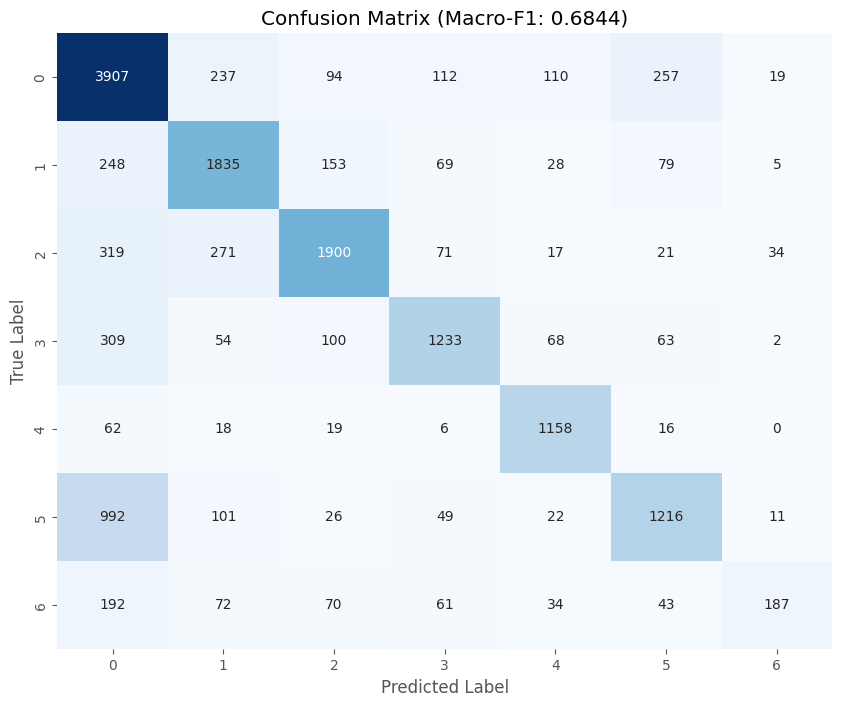

In [ ]:
# Predict on Validation Data
print("Predicting on Validation set...")
y_pred = mnb.predict(X_val_processed)

# Evaluate
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"\n>>> MACRO-F1 SCORE: {macro_f1:.4f} <<<")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix 
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Macro-F1: {macro_f1:.4f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# EXPERIMENTATION GRID


Training Naive Bayes (Multinomial)...


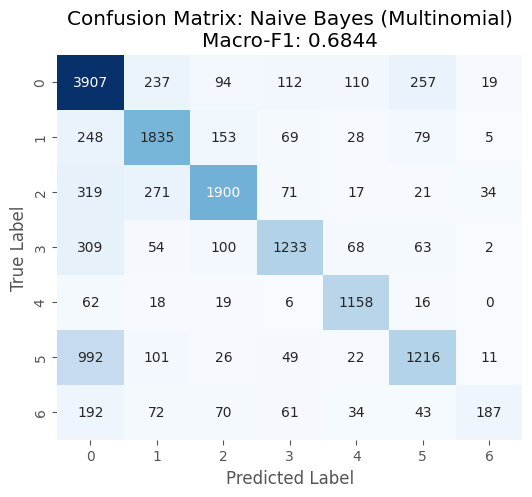


Training Logistic Regression (C=0.1) (unbalanced)...


/Users/berkcalisir/School&Career/school-docs/Data Science Lab/Winter Project/Akkiprik_Calisir_DSML_Winter/.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


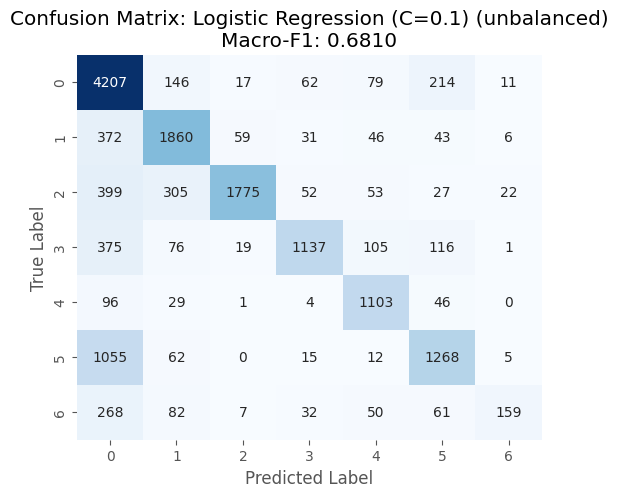


Training Logistic Regression (C=0.1)...


/Users/berkcalisir/School&Career/school-docs/Data Science Lab/Winter Project/Akkiprik_Calisir_DSML_Winter/.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


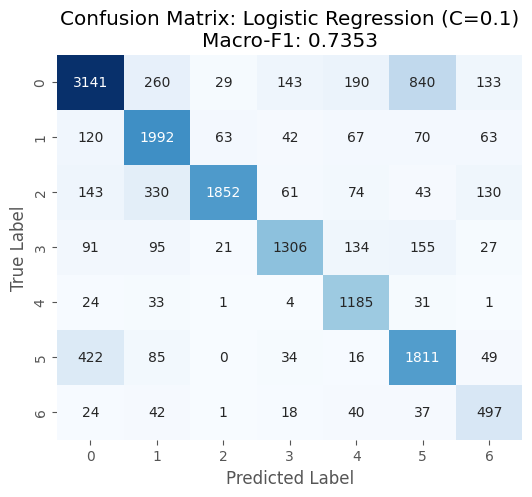


Training Logistic Regression (C=1.0)...


/Users/berkcalisir/School&Career/school-docs/Data Science Lab/Winter Project/Akkiprik_Calisir_DSML_Winter/.venv/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


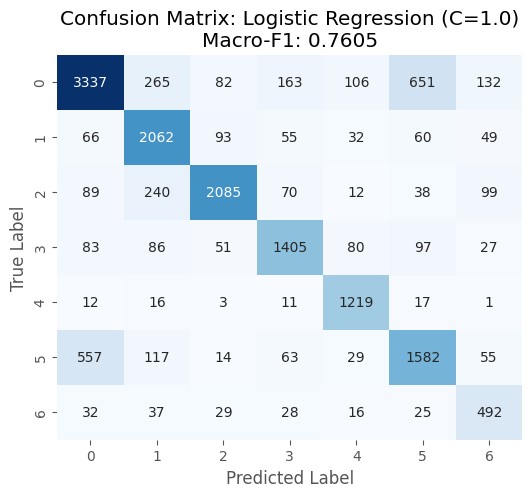


Training Linear SVM (C=0.1)...


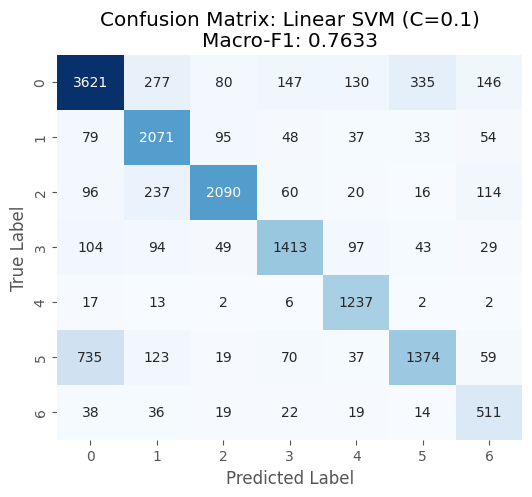


=== TOURNAMENT LEADERBOARD ===
                                      Model        F1       Time
4                        Linear SVM (C=0.1)  0.763344  11.337799
3               Logistic Regression (C=1.0)  0.760502   6.809427
2               Logistic Regression (C=0.1)  0.735321   6.959798
0                 Naive Bayes (Multinomial)  0.684409   0.045429
1  Logistic Regression (C=0.1) (unbalanced)  0.681015   7.144730


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


models = [
    {'name': 'Naive Bayes (Multinomial)', 'model': MultinomialNB()},
    {'name': 'Logistic Regression (C=0.1) (unbalanced)', 
     'model': LogisticRegression(C=0.1, solver='saga', random_state=SEED)},
    {'name': 'Logistic Regression (C=0.1)', 
     'model': LogisticRegression(C=0.1, class_weight='balanced', solver='saga', random_state=SEED)},
    {'name': 'Logistic Regression (C=1.0)', 
     'model': LogisticRegression(C=1.0, class_weight='balanced', solver='saga', random_state=SEED)},
    {'name': 'Linear SVM (C=0.1)', 
     'model': LinearSVC(C=0.1, class_weight='balanced', random_state=SEED, dual=False)}
]

results = []

for entry in models:
    print(f"\nTraining {entry['name']}...")
    start = time.time()
    
    # Train & Predict
    clf = entry['model']
    clf.fit(X_train_processed, y_train)
    preds = clf.predict(X_val_processed)
    
    # Score
    f1 = f1_score(y_val, preds, average='macro')
    elapsed = time.time() - start
    
    results.append({'Model': entry['name'], 'F1': f1, 'Time': elapsed})
    
    # VISUALIZE: Confusion Matrix for this specific model
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {entry['name']}\nMacro-F1: {f1:.4f}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Final Leaderboard
print("\n=== TOURNAMENT LEADERBOARD ===")
leaderboard = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print(leaderboard)

The model is excellent at identifying distinct topics like Sports (Class 4) and Technology (Class 2). However, it is failing at distinguishing International News (Class 0) from General News (Class 5).

749 misclassifications of Class 5 as Class 0 is big. 

The Likely Cause: "General News" is often a semantic "trash bin." It contains stories about local politics, minor international events, or human interest stories that look like International News (Class 0) but lack the specific geopolitical weight to be labeled as such.

We should extract the specific articles where the model predicted "International" (0) but the truth was "General" (5), or vice versa. 

Then, extract the Top Keywords that the LinearSVC & Logistic Regression uses to decide between Class 0 and Class 5.

In [25]:
# FINAL RETRAINING & SUBMISSION

print("Combining Data for Final Training")
X_full = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full = pd.concat([y_train, y_val]).reset_index(drop=True)

print(f"Full Training Data Shape: {X_full.shape}")

# REFIT FEATURE ENGINEERING (On Full Data)
# We refit transformers to learn from the validation set too
print("\nRefitting Feature Engineering on Full Data")

# Source Encoding
top_sources_full = X_full['source'].value_counts().nlargest(200).index.tolist()
X_full_src = X_full['source'].apply(lambda x: x if x in top_sources_full else 'Other').values.reshape(-1, 1)

ohe_final = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_full_ohe = ohe_final.fit_transform(X_full_src)

# PageRank Scaling
scaler_final = MinMaxScaler()
X_full_pr = scaler_final.fit_transform(X_full['page_rank'].values.reshape(-1, 1))
from scipy.sparse import csr_matrix
X_full_pr_sparse = csr_matrix(X_full_pr)

# Text Vectorization
X_full_text = (X_full['source'].fillna('') + " " + X_full['title'].fillna('') + " " + X_full['article'].fillna(''))
tfidf_final = TfidfVectorizer(ngram_range=(1, 3), max_features=30000, sublinear_tf=True, min_df=5)
X_full_tfidf = tfidf_final.fit_transform(X_full_text)

# Concatenate
X_full_processed = hstack([X_full_tfidf, X_full_ohe, X_full_pr_sparse])
print(f"Final Feature Matrix Shape: {X_full_processed.shape}")

# TRAIN FINAL MODEL (LinearSVC)
print("Training Final Winner Model")
final_model = LinearSVC(C=0.1, class_weight='balanced', random_state=42, dual=False)
final_model.fit(X_full_processed, y_full)
print("Training Complete.")

# PREDICT ON EVALUATION SET
print("\nProcessing Test Set (evaluation.csv)")
# Load Test Data
test_df = pd.read_csv("dataset/evaluation.csv")

# Apply the EXACT same cleaning as training
for col in ['title', 'article', 'source']:
    test_df[col] = test_df[col].apply(scrub_artifacts)

# A. Source Transform (Use fitted ohe_final)
test_src = test_df['source'].apply(lambda x: x if x in top_sources_full else 'Other').values.reshape(-1, 1)
test_ohe = ohe_final.transform(test_src)

# B. PageRank Transform (Use fitted scaler_final)
test_pr = scaler_final.transform(test_df['page_rank'].values.reshape(-1, 1))
test_pr_sparse = csr_matrix(test_pr)

# C. Text Transform (Use fitted tfidf_final)
test_text = (test_df['source'].fillna('') + " " + test_df['title'].fillna('') + " " + test_df['article'].fillna(''))
test_tfidf = tfidf_final.transform(test_text)

# D. Concatenate
X_test_processed = hstack([test_tfidf, test_ohe, test_pr_sparse])
print(f"Test Feature Matrix Shape: {X_test_processed.shape}")

# Predict
test_predictions = final_model.predict(X_test_processed)

# CREATE SUBMISSION FILE
submission = pd.DataFrame({
    'Id': test_df['Id'], # Assuming 'Id' is the identifier column
    'Predicted': test_predictions
})

submission.to_csv("submission_linear_svc_full.csv", index=False)
print("\nSUCCESS: 'submission_linear_svc_full.csv' generated!")

Combining Data for Final Training
Full Training Data Shape: (79850, 8)

Refitting Feature Engineering on Full Data
Final Feature Matrix Shape: (79850, 30202)
Training Final Winner Model
Training Complete.

Processing Test Set (evaluation.csv)
Test Feature Matrix Shape: (20000, 30202)

SUCCESS: 'submission_linear_svc_full.csv' generated!


In [26]:
from sklearn.pipeline import Pipeline

print("\n=== FORENSIC ANALYSIS: CLASS 0 VS 5 ===")

# Isolate 0 vs 5 Data from Training Set
mask_05 = y_train.isin([0, 5])
X_forensic = X_train[mask_05].copy()
y_forensic = y_train[mask_05]

# Reconstruct Text Blob 
X_forensic_text = (
    X_forensic['source'].fillna('') + " " + 
    X_forensic['title'].fillna('') + " " + 
    X_forensic['article'].fillna('')
)
# Train Binary "Probe" Model
# Using simple unigrams to capture semantic keywords clearly
probe_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words='english')),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])
probe_pipe.fit(X_forensic_text, y_forensic)

# Extract & Print Feature Importance
feature_names = probe_pipe.named_steps['tfidf'].get_feature_names_out()
coefs = probe_pipe.named_steps['clf'].coef_.flatten()

# Class 0 is negative class, Class 5 is positive class in binary mode (usually sorted)
# We sort coefficients: lowest = Class 0 predictors, highest = Class 5 predictors
top_k = 20
top_class_5_idx = coefs.argsort()[-top_k:][::-1]
top_class_0_idx = coefs.argsort()[:top_k]

print(f"\nTop 20 words driving prediction towards CLASS 0 (International/Wire?):")
print(feature_names[top_class_0_idx])

print(f"\nTop 20 words driving prediction towards CLASS 5 (Topics/Soft News?):")
print(feature_names[top_class_5_idx])


=== FORENSIC ANALYSIS: CLASS 0 VS 5 ===

Top 20 words driving prediction towards CLASS 0 (International/Wire?):
['yahoo' 'rednova' 'topix' 'ap' 'afp' 'net' 'csmonitor' 'boston' 'bbc'
 'ips' 'cqpolitics' 'nation' 'arab' 'new' 'africa' '130' 'yimg' 'feeds'
 'irish' 'german']

Top 20 words driving prediction towards CLASS 5 (Topics/Soft News?):
['cnn' 'topstories' 'guardian' '39' 'newsweek' 'www' 'cbs' 'newsisfree'
 'seattle' 'info' 'cnn_topstories' 'amp' 'voice' 'george'
 'a8a276f7a37a42499f8b1c69f9acf191' 'forbes' 'com' 'phdo' 'pheedo'
 'update']


In [27]:
# Source Overlap

# Crosstab of Source vs Label for 0 and 5
# We use the raw X_train source column before OHE
source_forensic = X_train.loc[mask_05, 'source']
source_counts = pd.crosstab(source_forensic, y_forensic)

# Filter for sources meaningful in BOTH classes
# (Sources with at least 10 samples in each class)
shared_sources = source_counts[(source_counts[0] > 10) & (source_counts[5] > 10)]

print(f"\n=== SHARED SOURCE ANALYSIS ===")
print(f"Number of sources substantially shared between 0 and 5: {len(shared_sources)}")

if not shared_sources.empty:
    print("\nTop Shared Sources (contributing to confusion):")
    # Sort by total volume
    print(shared_sources.assign(Total=shared_sources.sum(axis=1)).sort_values(by='Total', ascending=False).head(10))
else:
    print("No significant source overlap found.")


=== SHARED SOURCE ANALYSIS ===
Number of sources substantially shared between 0 and 5: 49

Top Shared Sources (contributing to confusion):
label          0     5  Total
source                       
Yahoo       6452    17   6469
BBC         3307  1644   4951
Reuters     2373  2340   4713
CNN           58  1282   1340
Washington   644   458   1102
New          717   200    917
Boston       385    88    473
Time         195   182    377
Guardian      91   286    377
ABC          118   147    265


In [39]:
def save_artifact_rows():
    df_train = pd.read_csv('./dataset/development.csv')
    df_test = pd.read_csv('./dataset/evaluation.csv')
    print(f"Original Dev Shape: {df_clean.shape}")
    print(f"Original Eval Shape: {df_test.shape}")

    # 2. Define the "Leakage" Artifacts
    artifacts = ['newsisfree', 'topstories', 'pheedo', 'click.phdo']
    # Create regex pattern: (newsisfree|topstories|pheedo|...)
    pattern = '|'.join(artifacts)

    # 3. Filter Rows (Check Title + Article)
    # Using 'fillna' to handle potential NaNs before string search
    dev_mask = (df_train['title'].fillna('').str.contains(pattern, case=False, regex=True)) | \
               (df_train['article'].fillna('').str.contains(pattern, case=False, regex=True))
               
    eval_mask = (df_train['title'].fillna('').str.contains(pattern, case=False, regex=True)) | \
                (df_train['article'].fillna('').str.contains(pattern, case=False, regex=True))

    dev_affected = df_train[dev_mask]
    eval_affected = df_test[eval_mask]

    # 4. Save to CSV for inspection
    dev_affected.to_csv('./dataset/development_artifacts.csv', index=False)
    eval_affected.to_csv('./dataset/evaluation_artifacts.csv', index=False)

    print(f"\n--- Artifact Analysis ---")
    print(f"Development Rows with Artifacts: {len(dev_affected)} ({len(dev_affected)/len(df_clean):.1%})")
    print(f"Evaluation Rows with Artifacts: {len(eval_affected)} ({len(eval_affected)/len(df_test):.1%})")
    
    # 5. Preview a few examples to see the "On CNN" pattern
    print("\n--- Example Affected Rows ---")
    if not dev_affected.empty:
        print(dev_affected[['article', 'label']].head(3).to_string())

# Run it
save_artifact_rows()

Original Dev Shape: (79854, 9)
Original Eval Shape: (20000, 6)

--- Artifact Analysis ---
Development Rows with Artifacts: 1908 (2.4%)
Evaluation Rows with Artifacts: 482 (2.4%)

--- Example Affected Rows ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_19464/3100809719.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_affected = df_test[eval_mask]
